In [206]:
#Impor Relevant Packages
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

***Purpose***

The purpose of this project was to analyze a dynamic control process using reinforcement learning by focusing on a simplified view of the **Colorado River Basin**.  Specifically, we analyzed four dams:
**A - Glen Canyon, B - Hoover, C - Davis, and D - Parker**  

We subsequently analyzed water and electricity market interactions with 8 "downstream" communities subject to the actions at each of these stations.  Those communities were 
***1 - St. George UT, 2 - Flagstaff AZ, 3 - Las Vegas NV, 4 - Kingman AZ, 5 - Barstow CA, 6 - Prescott AZ, 7 - Los Angeles CA, and 8 - Green Valley AZ***. Data from 0 - Colorado Spring CO was also used for upstream inputs. 

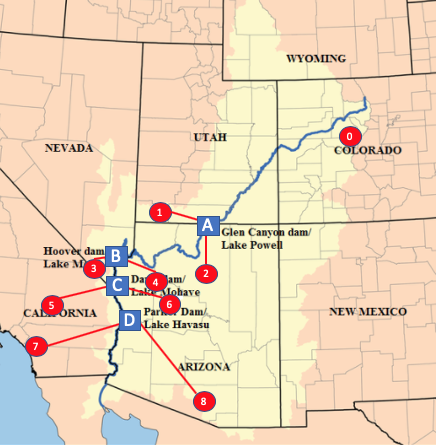

***Strategy***

We used the SARSA algorithm with a time adjustment for quarterly updates despite daily action states.  The Q-table was interpreted in an epsilon greed fashion with lambda decay over the course of each period.  

Actions for all other dams were fixed and a dynamic pricing system introduced in order to introduce sufficient variation while maintaining a clean approach for control.

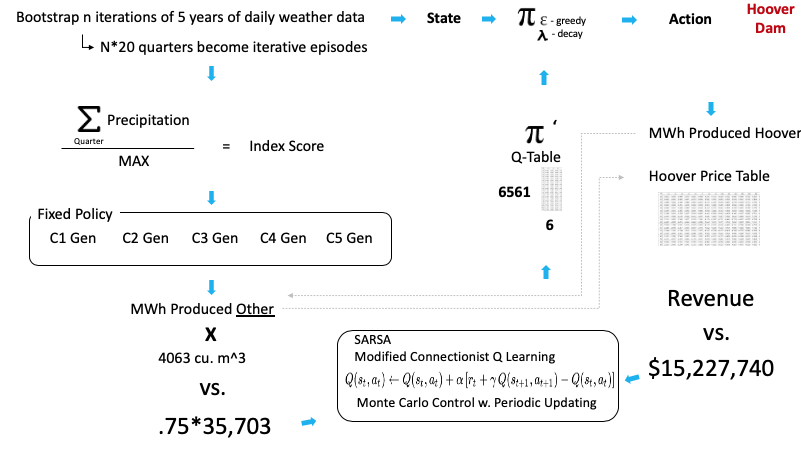

In [207]:
##
###  Data Pulls
##

#5 Years of historical precipitation data for each of our nine "proxy regions" - pulled via NOAA API
PrecipMast = pd.read_csv('MasterPrecip.csv')  

#Pull in @ Table w. 6561 states and 6 Actions for each day
QTable = pd.read_csv('RLHydro_QFin.csv')  
QTable=QTable.drop_duplicates()

#Pull in DamGen Data for Different Demand States
DamGen = pd.read_csv('DamGen.csv')

#Pricing Table for HOover
PriceHold = pd.read_csv('HooverPrice.csv')

#StateActionHolder
StateActionHold = pd.read_csv('StateActionHold.csv')

PrecipMast.head()

,DATE,COLSPR,STGEORGE,FLAGSTAFF,VEGAS,KINGMAN,BARSTOW,PRESCOTT,LOSANG,GREENVAL
0,1/1/15,0.59,0.05,3.72,0.0,0.27,0.0,3.60,0.01,4.72
1,1/2/15,4.14,0.00,0.51,0.3,0.00,0.0,0.26,0.00,0.00
2,1/3/15,0.00,0.00,0.60,0.0,0.00,0.0,0.00,0.00,0.00
3,1/4/15,0.26,0.00,0.00,0.2,0.00,0.0,0.00,0.00,0.00
4,1/5/15,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00


In [208]:
def initzero(df):
    NewZero=df
    NewZero.loc[:,1:] = 0.00
    return NewZero

In [209]:
#Bootstrap parameters pick from all days +/- 10 within 2 years
PlusMinusList = [355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375]
TimesList = [0,1,2]
QuartStop = [89, 180, 272, 364, 455, 546, 638, 730, 820, 911, 1003, 1095, 1185, 1276, 1368, 1460, 1550, 1641, 1733, 1825]
QuartDx = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]

In [210]:
#Initite 5 Years Worth of BootStrapped Data and return all dates and summaries
def bootstrap(df):
    Tester = initzero(df.copy())
    Tester
    for column in Tester.columns[1:]:
        for row in Tester.index:
            myrand = random.choice(PlusMinusList)*random.choice(TimesList)
            mover = 0
            if row + myrand < 1826:
                mover = row + myrand
            elif row - myrand > 0:
                mover = row - myrand
            else:
                mover = row
            UpVal = PrecipMast[column][mover]
            #5% of the time... have a shock up or down by 20%
            if np.random.random()>.95:
                if np.random.random() >.5:
                    UpVal = UpVal*1.2
                else:
                    UpVal = UpVal*.8
            Tester[column][row]=UpVal
            
    QuartHold = pd.read_csv('QuartHold.csv') 
    for column in QuartHold.columns[1:]:
        startrow=0
        for row in range(len(QuartStop)):
            endrow=QuartStop[row]
            thissum = Tester.iloc[startrow:endrow, Tester.columns.get_loc(column)].sum()        
            QuartHold[column][row]= thissum
            startrow=endrow+1
        QuartHold[column][20]= QuartHold.iloc[0:3, QuartHold.columns.get_loc(column)].sum()    
        QuartHold[column][21]= QuartHold.iloc[4:7, QuartHold.columns.get_loc(column)].sum()
        QuartHold[column][22]= QuartHold.iloc[8:11, QuartHold.columns.get_loc(column)].sum()
        QuartHold[column][23]= QuartHold.iloc[12:15, QuartHold.columns.get_loc(column)].sum()
        QuartHold[column][24]= QuartHold.iloc[16:19, QuartHold.columns.get_loc(column)].sum()
            
    
    return Tester, QuartHold

In [211]:
#Routine for extracting state for a given line, can be stored in "state table"
GlenCanyonThresh =[28.3,47.1,84.8,141.4]  
HooverThresh=[3.9,6.4,11.6,19.3]
DavisThresh=[10.1,16.8,30.3,50.4]
ParkerThresh=[15.3,25.5,45.9,76.5]
def calcstate(df, thisday):
    holder=[]
    if thisday<30:
        
        holder = ['M','M','M','M','M','M','M','M']
        
    elif thisday <90:
        thirtydayprior=thisday-30
        
        #GlenCanyonThirty
        GlenCanyonThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('COLSPR')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('STGEORGE')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('FLAGSTAFF')].sum()
        if GlenCanyonThirtyTot < GlenCanyonThresh[0]:
            GlenCanyonThirtyState='L'
        elif GlenCanyonThirtyTot < GlenCanyonThresh[1]:
            GlenCanyonThirtyState='M'
        else:
            GlenCanyonThirtyState='H'
        
        #HooverThirty
        HooverThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('VEGAS')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('KINGMAN')].sum() 
        if HooverThirtyTot < HooverThresh[0]:
            HooverThirtyState='L'
        elif HooverThirtyTot < HooverThresh[1]:
            HooverThirtyState='M'
        else:
            HooverThirtyState='H'
        
        #DavisThirty
        DavisThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('BARSTOW')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('PRESCOTT')].sum() 
        if DavisThirtyTot < DavisThresh[0]:
            DavisThirtyState='L'
        elif DavisThirtyTot < DavisThresh[1]:
            DavisThirtyState='M'
        else:
            DavisThirtyState='H'
        
        #ParkerThirty
        ParkerThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('LOSANG')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('GREENVAL')].sum() 
        if ParkerThirtyTot < ParkerThresh[0]:
            ParkerThirtyState='L'
        elif ParkerThirtyTot < ParkerThresh[1]:
            ParkerThirtyState='M'
        else:
            ParkerThirtyState='H'
            
        holder = [GlenCanyonThirtyState,'M',HooverThirtyState,'M',DavisThirtyState,'M',ParkerThirtyState,'M']
        
    else:
        thirtydayprior=thisday-30
        ninetydayprior=thisday-90
        
        #GlenCanyonThirty
        GlenCanyonThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('COLSPR')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('STGEORGE')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('FLAGSTAFF')].sum()
        if GlenCanyonThirtyTot < GlenCanyonThresh[0]:
            GlenCanyonThirtyState='L'
        elif GlenCanyonThirtyTot < GlenCanyonThresh[1]:
            GlenCanyonThirtyState='M'
        else:
            GlenCanyonThirtyState='H'
        
        #HooverThirty
        HooverThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('VEGAS')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('KINGMAN')].sum() 
        if HooverThirtyTot < HooverThresh[0]:
            HooverThirtyState='L'
        elif HooverThirtyTot < HooverThresh[1]:
            HooverThirtyState='M'
        else:
            HooverThirtyState='H'
        
        #DavisThirty
        DavisThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('BARSTOW')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('PRESCOTT')].sum() 
        if DavisThirtyTot < DavisThresh[0]:
            DavisThirtyState='L'
        elif DavisThirtyTot < DavisThresh[1]:
            DavisThirtyState='M'
        else:
            DavisThirtyState='H'
        
        #ParkerThirty
        ParkerThirtyTot= df.iloc[thirtydayprior:thisday, df.columns.get_loc('LOSANG')].sum() + df.iloc[thirtydayprior:thisday, df.columns.get_loc('GREENVAL')].sum() 
        if ParkerThirtyTot < ParkerThresh[0]:
            ParkerThirtyState='L'
        elif ParkerThirtyTot < ParkerThresh[1]:
            ParkerThirtyState='M'
        else:
            ParkerThirtyState='H'
        
        #TO DO UPDATE INDICES
        
        #GlenCanyonNinety
        GlenCanyonNinetyTot= df.iloc[ninetydayprior:thisday, df.columns.get_loc('COLSPR')].sum() + df.iloc[ninetydayprior:thisday, df.columns.get_loc('STGEORGE')].sum() + df.iloc[ninetydayprior:thisday, df.columns.get_loc('FLAGSTAFF')].sum()
        if GlenCanyonNinetyTot < GlenCanyonThresh[2]:
            GlenCanyonNinetyState='L'
        elif GlenCanyonNinetyTot < GlenCanyonThresh[3]:
            GlenCanyonNinetyState='M'
        else:
            GlenCanyonNinetyState='H'
        
        #HooverNinety
        HooverNinetyTot= df.iloc[ninetydayprior:thisday, df.columns.get_loc('VEGAS')].sum() + df.iloc[ninetydayprior:thisday, df.columns.get_loc('KINGMAN')].sum() 
        if HooverNinetyTot < HooverThresh[2]:
            HooverNinetyState='L'
        elif HooverNinetyTot < HooverThresh[3]:
            HooverNinetyState='M'
        else:
            HooverNinetyState='H'
        
        #DavisNinety
        DavisNinetyTot= df.iloc[ninetydayprior:thisday, df.columns.get_loc('BARSTOW')].sum() + df.iloc[ninetydayprior:thisday, df.columns.get_loc('PRESCOTT')].sum() 
        if DavisNinetyTot < DavisThresh[2]:
            DavisNinetyState='L'
        elif DavisNinetyTot < DavisThresh[3]:
            DavisNinetyState='M'
        else:
            DavisNinetyState='H'
        
        #ParkerNinety
        ParkerNinetyTot= df.iloc[ninetydayprior:thisday, df.columns.get_loc('LOSANG')].sum() + df.iloc[ninetydayprior:thisday, df.columns.get_loc('GREENVAL')].sum() 
        if ParkerNinetyTot < ParkerThresh[2]:
            ParkerNinetyState='L'
        elif ParkerNinetyTot < ParkerThresh[3]:
            ParkerNinetyState='M'
        else:
            ParkerNinetyState='H'
        
        holder = [GlenCanyonThirtyState,GlenCanyonNinetyState,HooverThirtyState,HooverNinetyState,DavisThirtyState,DavisNinetyState,ParkerThirtyState,ParkerNinetyState]
        
    state=''
    for i in range(len(holder)):
        state= state + holder[i]
    return state

In [212]:
#Get States and Actions for All Days And Store Them
def storeStateAction (start, end, df, epsilon): 
    for row in range(start,end): #
        thisstate = calcstate(df,row)
        StateActionHold['STATE'][row] = thisstate
        thisaction = ActionSelect(StateActionHold['STATE'][row], epsilon)
        StateActionHold['ACTION'][row] = thisaction
        StateActionHold['DISCOUNTER'][row] = end-(row-start)
    return 

In [226]:
#PolicyImplement
def ActionSelect (thistate, epsilon):
    myarray=[]
    IndexHold = QTable.index[QTable.State == thistate]
    if len(IndexHold)!=1:
        if len(IndexHold) ==0:
            IndexHold = 100
        else:
            IndexHold=IndexHold[0]    
    myarray= [int(QTable.Hold_NoPump[IndexHold]), int(QTable.Hold_LitePump[IndexHold]), int(QTable.Hold_Pump[IndexHold]), int(QTable.Run_NoPump[IndexHold]), int(QTable.Run_LitePump[IndexHold]), int(QTable.Run_Pump[IndexHold])]
    for i in range(len(myarray)):
        trand=np.random.random()*.0001
        myarray[i]=myarray[i]+trand
    result = np.where(myarray == np.amax(myarray))[0] + 1
    
    if np.random.random()>1-epsilon:
        result=np.random.randint(1,6)
    
    ActionSelect=QTable.columns[result]
    
    return ActionSelect

In [215]:
#Calculate Hoover Revenues for each day of the quarter and return the quarterly totals of revenue and production

def getHooverRevenue (Hooverprice, start, stop):
    totalHooverRevenue = 0
    totalProduction = 0
    for row in range (start, stop):
        if StateActionHold['ACTION'][row] == "Hold_NoPump":
            production = 0
        if StateActionHold['ACTION'][row] == "Hold_LitePump":
            production = 0
        if StateActionHold['ACTION'][row] == "Hold_Pump":
            production = 0       
        if StateActionHold['ACTION'][row] == "Run_NoPump":
            production = 10429*1000
        if StateActionHold['ACTION'][row] == "Run_LitePump":
            production = 10429*1000
        if StateActionHold['ACTION'][row] == "Run_Pump":
            production = 10429*1000
        totalHooverRevenue = totalHooverRevenue + (production * Hooverprice)
        totalProduction = totalProduction + production
    return totalHooverRevenue, totalProduction                   

In [213]:
def updatePolicy (start, end, StateActionHold, TotalReward, alpha, beta): 
    for row in range(start,end): 
        discount = (1-beta)**(StateActionHold['DISCOUNTER'][row]-1)
        state = StateActionHold['STATE'][row]
        action = StateActionHold['ACTION'][row]
        index = QTable.index[QTable.State == state]
        if len(action[0])==1:
            QPrior = QTable[action][index]
        else:
            QPrior = QTable[str(action[0])][index]
        NewQ = QPrior + (alpha*(TotalReward*discount - QPrior))
        if len(action[0])==1:
            QTable[action][index] = NewQ
        else:
            QTable[action[0]][index] = NewQ 
    return 

In [225]:
#Reinitiate Q Table and percent trackers
QTable = pd.read_csv('RLHydro_QFin.csv')  
QTable=QTable.drop_duplicates()
RevenuePerc = []

/Users/tester/opt/anaconda3/envs/EarthEngine/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tester/opt/anaconda3/envs/EarthEngine/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tester/opt/anaconda3/envs/EarthEngine/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tes

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


/Users/tester/opt/anaconda3/envs/EarthEngine/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


Text(0, 0.5, 'Perc. of Norm Revenue')

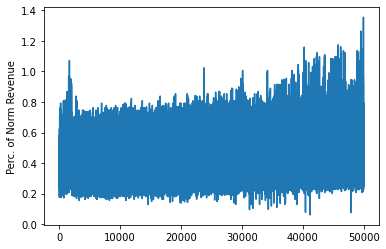

In [228]:
t = time.time()

#Set Number of Simulation (Each Simulation is 5 Years or 20 Quarters)
#each update takes ~.6 seconds to run... or ~36 seconds per num_run... or 1 hr. per 100 num_run
num_run=2400


#Set Hyperparameters... 
epsilon_start = 1
epsilon_end = 0
epsilon_decay = (epsilon_start-epsilon_end)/num_run
alpha_start = .1
alpha_end = .001
alpha_decay = (alpha_start-alpha_end)/num_run
beta = .02


GlenCanyonMaxRain = 593.4
DavisMaxRain=228.0
ParkerMaxRain=436.5

HooverCurr = .75*35703 
HooverAvRev = 15227740

MaxThres = [.6, .8, 1, 1.5]
AvThres = [.6, .8, 1, 1.2]

#  def runSim (thisboot, epsilon)


#Loop Through Number of Simulations
for i in range (0, num_run):
    #determine epsilon and alpha for this sequence
    epsilon = epsilon_start - (i*epsilon_decay)
    alpha = alpha_start - (i*alpha_decay)
    
    #get a new 5 year bootstrap
    thisboot, bootsum = bootstrap(PrecipMast)
    
    #loop through all days in the bootstrap
    for row in thisboot.index: 
        
        #get states and actions for the day
        thisstate = calcstate(thisboot,row)
        thisaction = ActionSelect(thisstate, epsilon)
        
        #most actions occur only if we are at the end of a quarter
        if row in QuartStop:
            indx = QuartStop.index(row)
            QrtDx = QuartDx[indx]

            if indx == 0:
                storeStateAction (0, row+1, thisboot, epsilon)
            else:
                storeStateAction (QuartStop[indx-1], row+1, thisboot, epsilon)

                
            #Determine production for non Hoover areas using bootstrap values as percentage of Max observed    
            GlenCanPerc = (bootsum['COLSPR'][indx] + bootsum['STGEORGE'][indx] + bootsum['FLAGSTAFF'][indx]) / GlenCanyonMaxRain
            DavisPerc = (bootsum['BARSTOW'][indx] + bootsum['PRESCOTT'][indx]) / DavisMaxRain
            ParkerPerc = (bootsum['LOSANG'][indx] + bootsum['GREENVAL'][indx]) / DavisMaxRain

            #GlenCanProd
            if GlenCanPerc < MaxThres[0]:
                GlenCanProd = DamGen['GLENCAN'][4]
            elif GlenCanPerc < MaxThres[1]:
                GlenCanProd = DamGen['GLENCAN'][3]
            elif GlenCanPerc < MaxThres[2]:
                GlenCanProd = DamGen['GLENCAN'][2]
            elif GlenCanPerc < MaxThres[3]:
                GlenCanProd = DamGen['GLENCAN'][1]
            else:
                GlenCanProd = DamGen['GLENCAN'][0]

            #DavisProd
            if DavisPerc < MaxThres[0]:
                DavisProd = DamGen['DAVIS'][4]
            elif DavisPerc < MaxThres[1]:
                DavisProd = DamGen['DAVIS'][3]
            elif DavisPerc < MaxThres[2]:
                DavisProd = DamGen['DAVIS'][2]
            elif DavisPerc < MaxThres[3]:
                DavisProd = DamGen['DAVIS'][1]
            else:
                DavisProd = DamGen['DAVIS'][0]

            #ParkerProd
            if ParkerPerc < MaxThres[0]:
                ParkerProd = DamGen['PARKER'][4]
            elif ParkerPerc < MaxThres[1]:
                ParkerProd = DamGen['PARKER'][3]
            elif ParkerPerc < MaxThres[2]:
                ParkerProd = DamGen['PARKER'][2]
            elif ParkerPerc < MaxThres[3]:
                ParkerProd = DamGen['PARKER'][1]
            else:
                ParkerProd = DamGen['PARKER'][0]

            #HooverPrice -- Price is a function of production elsewhere
            AvProd = (GlenCanPerc + DavisPerc + ParkerPerc)/3
            if AvProd < AvThres[0]:
                HooverPrice = PriceHold['C5'][QrtDx]          #TODO: QrtDx
            elif AvProd < AvThres[1]:
                HooverPrice = PriceHold['C4'][QrtDx]
            elif AvProd < AvThres[2]:
                HooverPrice = PriceHold['C3'][QrtDx]
            elif AvProd < AvThres[3]:
                HooverPrice = PriceHold['C2'][QrtDx]
            else:
                HooverPrice = PriceHold['C1'][QrtDx]

            #HooverRevenueandProduction -- Function of price
            if indx == 0:
                HooverRevenue, HooverProd = getHooverRevenue(HooverPrice, 0, row+1)
            else:
                HooverRevenue, HooverProd = getHooverRevenue(HooverPrice, QuartStop[indx-1], row+1)



            #HooverHydrology - Monitor Hoover Water Levels
            GlenCanContro = GlenCanProd * 4063.33 * 1000 #cubic meters of water released by GlenCanContro
            HooverLoss = HooverProd * 4063.33
            TribX = bootsum['COLSPR'][indx] + bootsum['STGEORGE'][indx] + bootsum['FLAGSTAFF'][indx] + bootsum['VEGAS'][indx] + bootsum['KINGMAN'][indx]
            HooverTrib = 88401.87*np.log(TribX) - 300718.83
            Net = GlenCanContro + HooverTrib - HooverLoss 
            HooverCurr = HooverCurr + Net

            #SetUpRewardFunction
            #Net/HooverCurr more than 5% eitherway is a penalty... less is a reward
            RevRewardPerc = HooverRevenue/HooverAvRev
            HydroRewardPerc = Net/HooverCurr

            if RevRewardPerc > 1:
                RevReward = RevRewardPerc * 100
            elif RevRewardPerc <=1:
                RevReward = (1-RevRewardPerc) * -100

            if HydroRewardPerc >.05:
                HydroReward = -100
            elif HydroRewardPerc <-.05:
                HydroReward = -100
            else:
                HydroReward = 100

            TotalReward = RevReward + HydroReward


            #DisperseReward and Update Q-Table 
            if indx == 0:
                updatePolicy (0, row+1, StateActionHold, TotalReward, alpha, beta)
            else:
                updatePolicy (QuartStop[indx-1], row+1, StateActionHold, TotalReward, alpha, beta)
        
            RevenuePerc.append(RevRewardPerc)
            print(".")

elapsed = time.time() - t
print("Time elapsed was:")
print(elapsed)
print("seconds")

plt.plot(RevenuePerc)
plt.ylabel('Perc. of Norm Revenue')

        
    

In [235]:
RevenuePerc[4994]

0.2925072640515272

In [ ]:
#Print Out Q Table To View Up To Date Policy
QTable